## Einrichtung von Julia JuMP
---

Überprüfen Sie die bereits installierten Pakete. In der JuliaBox sind möglicherweise alle notwendigen Pakete bereits vorhanden.


In [1]:
using Pkg;
Pkg.status()

    Status `~/.julia/environments/v1.2/Project.toml`
  [336ed68f] CSV v0.5.16
  [a93c6f00] DataFrames v0.19.4
  [60bf3e95] GLPK v0.11.4
  [3c7084bd] GLPKMathProgInterface v0.4.4
  [7073ff75] IJulia v1.20.0
  [4076af6c] JuMP v0.20.0
  [f3b207a7] StatsPlots v0.12.0


Installieren Sie ``JuMP`` , mit dem Sie einfach Optimierungsprogramme formulieren können. Sowie ``GLPK`` einen open-source Solver zum Lösen der Problem und ``StatsPlots`` zur Visualisierung der Lösung.


In [2]:
#Pkg.add("JuMP")
#Pkg.add("GLPK");
#Pkg.add("StatsPlots");

Initialisieren Sie die installierten Pakete, damit sie im folgenden Notebook verwendet werden können.

In [3]:
using JuMP, GLPK, StatsPlots;

# Produktionsprogrammplanung
### Entscheidungsvariablen:
Bestimmung der optimalen **Produktionsmengen** der einzelnen Produkte,

### Zielfunktion:
0) **Deckungsbeitragsmaximierung**: $ \qquad \max db = \displaystyle\sum_{i=1}^I(e_i - k_i^v)\cdot X_i $



### Nebenbedingungen:


1) **Kapazitätsrestriktion:** $\hspace{50mm} \sum_{i=1}^I(r_{ij}\cdot X_i) \leq c_j \hspace{29mm} \forall j \in J $

2) **Absatzobergrenze:** $ \hspace{54mm} X_i \leq d_i \hspace{49mm} \forall i \in I $

3) **Nichtnegativitätsbedingung:** $ \hspace{38mm} X_i \geq 0 \hspace{50mm}    \forall i \in I $


* * * 


## Verwendete Symbole

### Mengen

$i \in (1,..,I) \hspace{20mm}$ Produkte

$j \in (1,..,J) \hspace{20mm}$ Ressourcen




### Variablen

$X_i$     $\geq0 \hspace{30mm}$ Produktionsmenge





### Parameter 

$e_i \hspace{39mm}$   Erlös von Produkt i  

$k_i^v \hspace{38mm}$  Variable Kosten bei Herstellung von Produkt i 

$d_i \hspace{39mm}$  Absatzobergrenze von Produkt i   

$r_{ij} \hspace{38mm}$  Produktionskoeffizient von Produkt i bezüglich Ressource j  

$c_j \hspace{39mm}$  Kapazität von Ressource j


* * *


## Erstellen Sie das Modell namens ``m`` und geben Sie als zu verwendenden Solver GLPK an.
---

In [4]:
m = Model(with_optimizer(GLPK.Optimizer));

# Auf diese Weise wird das Modell m erstellt
# In Klammern wird angegeben, dass der Solver GLPK zur Lösung des Modells herangezogen wird

### Mengen und Parameter

Fügen Sie die Mengen ein.

In [5]:
#Mengen
Produkte =   ["Normal", "Grande"];
Ressourcen = ["Plattenherstellung", "Lackieren", "Montage"];

# Mengen werden auf diese Weise erstellt. 
# Sind die Mengenelemente Worte, werden diese in Anführungszeichen gesetzt

#Längen
I = length(Produkte);
J = length(Ressourcen);

# Mit der Funktion length bestimmen wir die Anzahl der Elemente in den jeweiligen Mengen
# Diese Information benötigen wir später zur Erstellung von Variablen, Nebenbedingungen etc.

Fügen Sie die Parameter ein.

In [6]:
e  = [30, 40];          # Erlös von Produkt i
kv = [20, 25];          # variable Herstellkosten von Produkt i
d  = [100, 100];        # Nachfrage nach Produkt i
c =  [2400, 4000, 900]; # Kapazität von Ressource j

# Eindimensionale Parameter werden wie oben dargestellt eingegeben

      #Plattenherstellung, Lackieren, Montage
r  = [       6               20         4        #Normal
            20               20         9     ]; #Grande
#Produktionskoeffizient von Produkt i bezüglich Ressource j

# Zweidimensionle Parameter können als Matrix Dargestellt werden.
# Achten Sie darauf, dass die Zahlen der jeweiligen Spalten exakt untereinander stehen.

### Entscheidungsvariable
---
Definieren Sie die Entscheidungsvariable. Achten Sie auf den Definitionsbereich (Nebenbedingung 3).

3) **Nichtnegativitätsbedingung**: Da keine negativen Mengen der Produkte produziert werden können, wird zusätzlich eine Nichtnegativitätsbedingung eingeführt.

 $ \qquad X_i \geq 0 \qquad \qquad \qquad    \forall i \in I $

In [7]:
@variable(m, X[1:I] >= 0);

# mit der Funktion @variable wird eine neue Variable erstellt
# (m, gibt an, dass diese Variable dem oben erstellten Modell m zugeordnet ist
# Die Variable wird mit X bezeichnet
# und hat einen Index (i) der von 1 bis I (also 2) läuft
# innerhalb des Definitionsbereiches kann mit >=0 direkt die Nichtnegativitätsbedingung eingegeben werden
# [Binärvariablen könnten Alternativ mit der Information ",Bin" angegeben werden]

## Zielfunktion

0) **Deckungsbeitragsmaximierung**: Der Gesamtdeckungsbeitrag db soll maximiert werden. Dieser berechnet sich aus der Summe der einzelnen Produktdeckungsbeiträge (Produkterlös abzüglich variabler Kosten), multipliziert mit den entsprechenden Produktionsmengen der verschiedenen Güter.

$ \qquad \max db = \displaystyle\sum_{i=1}^I(e_i - k_i^v)\cdot X_i $ 

 * * *
 

In [8]:
@objective(m, Max,  sum((e[i] - kv[i]) * X[i] for i=1:I));

# Die Funktion @objective(m, erstellt eine Zielfunktion für das Modell m
# mit sum( wird eine Summe abgebildet
# der Bereich über den summiert wird steht hinter dem for
# hier wird über alle i (also alle Produkte) von 1 bis I summiert

## Nebenbedingungen


1) **Kapazitätsrestriktion**: Eventuell gibt es für die Ressoucen Kapazitätsbeschränkungen für die auf ihnen mögliche Produktionszeit. Die Summe der Gesamtproduktionszeit aller Produkte i= 1,...,I auf den einzelnen Ressourcen j darf dann die jeweils verfügbare Kapazität $ c_j $  nicht überschreiten.

$\qquad \sum_{i=1}^I(r_{ij}\cdot X_i) \leq c_j \qquad \forall j \in J $



In [9]:
@constraint(m, KapRes[j=1:J], sum(r[i,j] * X[i] for i=1:I) <= c[j] );

# Nebenbedingungen werden mit der Funktion @constraint eingegeben
# Nebenbedingungen erhalten einen Namen, in diesem Fall KapRes
# In eckigen Klammern nach dem Namen wird angegeben für welche Indizes diese Nebenbedingung erstellt werden soll
# Hier wird je eine Nebenbedingung für alle j (also Ressourcen) von 1 bis J (also 1-3) erstellt

2) **Absatzobergrenze**: Es besteht die Möglichkeit, dass für die Produkte Absatzobergrenzen basierend auf der Nachfrage existieren. Die produzierte Menge der einzelnen Produkte i darf dann diese Absatzobergrenze nicht überschreiten.

 $ \qquad X_i \leq d_i \qquad \qquad \qquad \forall i \in I $


In [10]:
@constraint(m, AbsOb[i=1:I], X[i] <= d[i]);

## Lösen Sie das Modell.
---

In [11]:
optimize!(m)

# mit dem Befehl optimize! wird das soeben erstellte Modell gelöst

Lassen Sie sich das Gesamtmodell anzeigen.

In [12]:
m

# führen Sie ausschließlich m aus wird, können Sie sich das mathematische Modell komplett anzeigen lassen

A JuMP Model
Maximization problem with:
Variables: 2
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 5 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: GLPK
Names registered in the model: AbsOb, KapRes, X

Lassen Sie sich den Zielfunktionswert anzeigen.


In [13]:
db = JuMP.objective_value(m)

# mit dem Befehl JuMP.objective_value(m) lassen Sie sich den Zielfunktionswert des gelösten Modells ausgeben
# hier wird der Zielfunktionswert zunächst dem Parameter db zugewiesen

println("Objective value db: ", round(Int64,db))

# anschließend wird der ZF-Wert ausgegeben
# dies erfolgt mit dem Befehl println
# "Objective value db: " ist der Text der vor dem ZF-Wert angezeigt werden soll

# Mit dem Befehl round(Int64, können wir Werte auf ganze Zahlen runden
# Beachten Sie, dass im Planspiel immer nur ganzzahlige Werte als Antwort erforderlich sind
# Nutzen Sie also round(Int64, um sich Werte ausgeben zu lassen


Objective value db: 1833


Lassen Sie sich die Produktionsmengen der einzelnen Schränke anzeigen.

In [14]:
JuMP.value.(X)

# Werte von Variablen lassen sich durch JuMP.value.( ) ausgeben (Beachten Sie den zweiten Punkt)

2-element Array{Float64,1}:
 100.0             
  55.55555555555556

Stellen Sie den Ressourcenverbrauch im Vergleich zur verfügbaren Kapazität graphisch dar.

In [15]:
bardata = (JuMP.value.(X) .* r)'

# Mit Hilfe von bardata können sie werte auch tabellarisch darstellen
# der Punkt vor dem * führt dazu, dass die beiden Vektoren X und r korrekt miteinander multipliziert werden
# das Anführungszeichen am Ende vertauscht x- und y-Achse der entstehenden Tabelle

3×2 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
  600.0  1111.11
 2000.0  1111.11
  400.0   500.0 

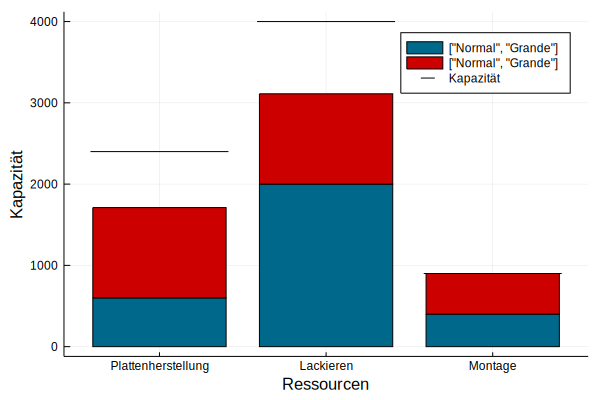

In [16]:
groupedbar(Ressourcen, bardata, bar_position = :stack, label =Produkte,  ylabel = "Kapazität", 
           xlabel ="Ressourcen", colour = [:DeepSkyBlue4 :Red3])
scatter!(Ressourcen, c, label="Kapazität", marker=(:hline, 68))

# Mit den Funktionen von StatsPlots lassen sich anschauliche Grafiken erstellen
# Schauen Sie sich die Dokumentation von StatsPlots im Internet an und experimentieren Sie mit Designs